<a href="https://colab.research.google.com/github/Kartikgc9/Prediction-Datasets/blob/main/Credit_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import folium

In [2]:
card_info = pd.read_csv('/content/cc_info.csv')
transaction_info = pd.read_csv('/content/transactions.csv')

In [3]:
card_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [4]:
transaction_info.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [5]:
#check for missing values
card_info.isnull().sum()

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

In [6]:
#check for missing values
transaction_info.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

In [7]:
#merge two dataframes
df = transaction_info.merge(card_info, on = 'credit_card')

In [8]:
df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [9]:
#shape of data
df.shape

(294588, 9)

<Axes: >

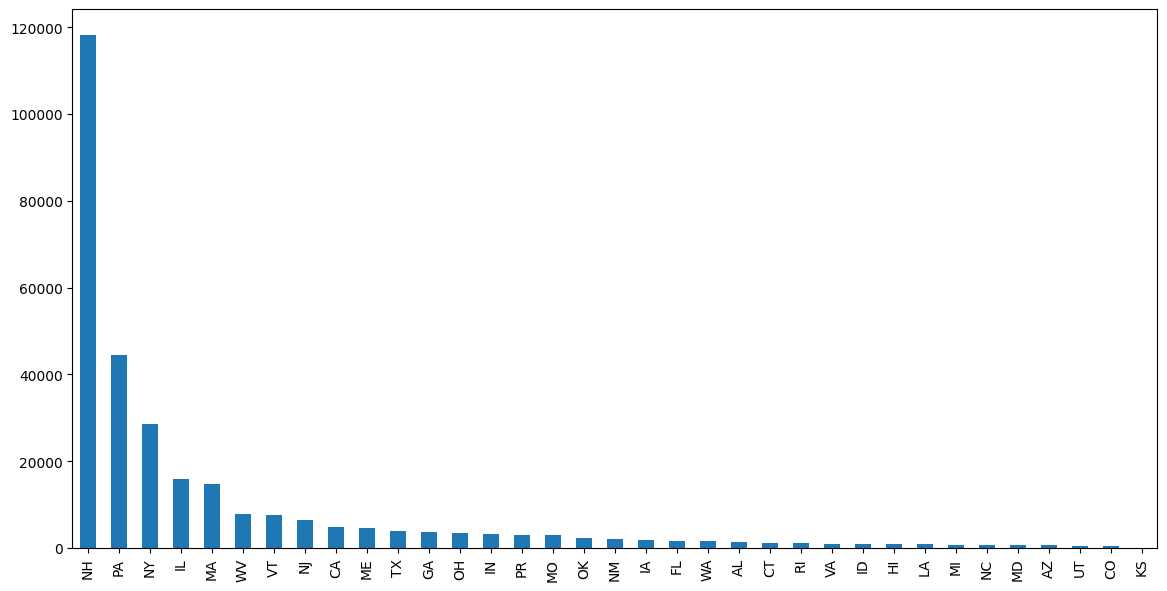

In [10]:
# Number of Transaction records state wise
df['state'].value_counts().plot(kind='bar', figsize = (14,7))

In [11]:
def visualize_total_transactions_on_map(df):
    city_total_transactions = df.groupby('city')['transaction_dollar_amount'].sum().reset_index()

    map_center_lat = df['Lat'].mean()
    map_center_lon = df['Long'].mean()
    map_osm = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=10)

    max_total_transactions = city_total_transactions['transaction_dollar_amount'].max()

    for index, row in city_total_transactions.iterrows():
        city = row['city']
        total_transactions = row['transaction_dollar_amount']

        marker_size = total_transactions / max_total_transactions * 50  # Adjust the scaling factor as needed

        popup_text = f"City: {city}<br>Total Transactions: ${total_transactions:.2f}"

        marker = folium.CircleMarker(
            location=[df[df['city'] == city]['Lat'].mean(), df[df['city'] == city]['Long'].mean()],
            radius=marker_size,
            popup=popup_text,
            tooltip=city,
            fill=True,
            fill_opacity=0.7
        )

        marker.add_to(map_osm)

    return map_osm

if __name__ == "__main__":

    map_total_transactions = visualize_total_transactions_on_map(df)
    display(map_total_transactions)

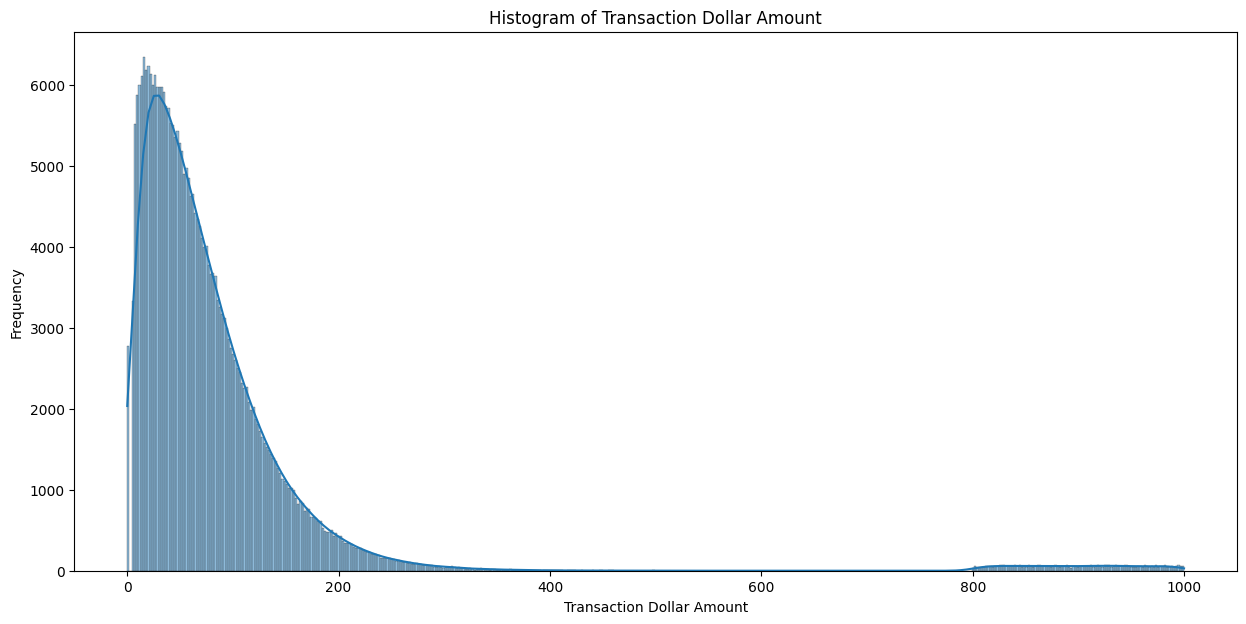

In [12]:
# Histogram of 'transaction_dollar_amount'

plt.figure(figsize=(15, 7))
sns.histplot(df['transaction_dollar_amount'], kde=True)
plt.title('Histogram of Transaction Dollar Amount')
plt.xlabel('Transaction Dollar Amount')
plt.ylabel('Frequency')
plt.show()

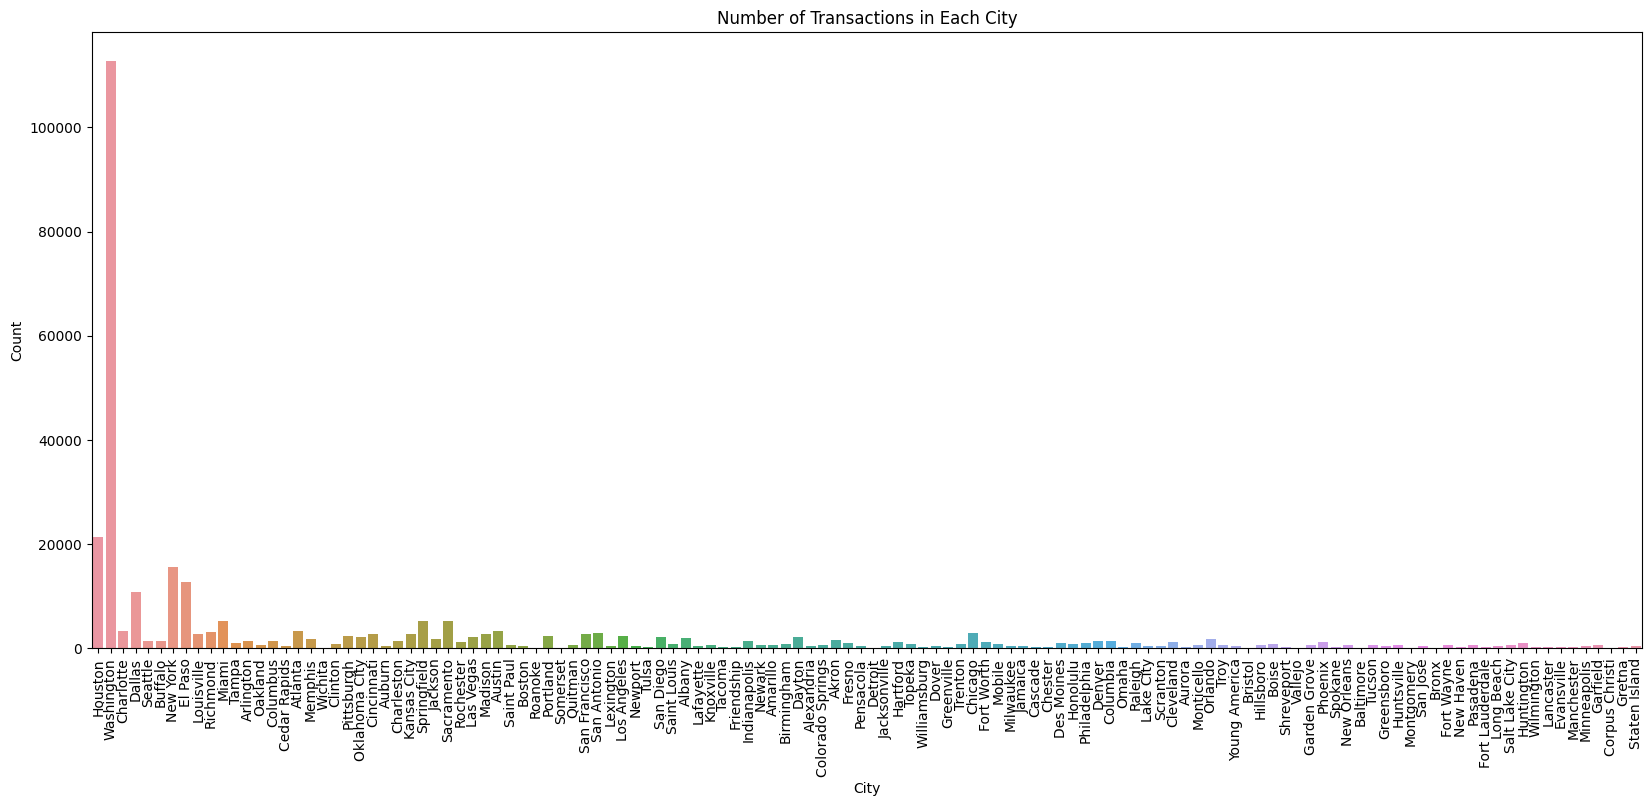

In [13]:
#Bar chart of the count of transactions in each city
plt.figure(figsize=(20, 8))
sns.countplot(data=df, x='city')
plt.title('Number of Transactions in Each City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

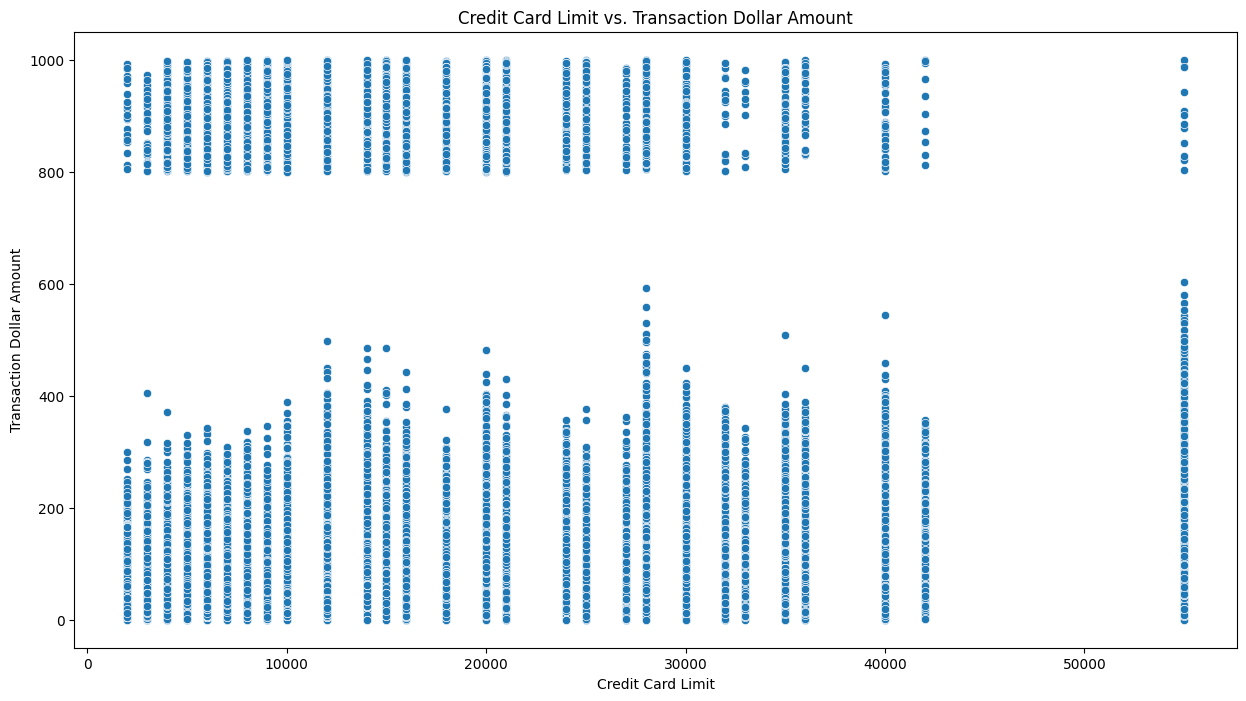

In [14]:
#'transaction_dollar_amount' vs. 'credit_card_limit'
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='credit_card_limit', y='transaction_dollar_amount')
plt.title('Credit Card Limit vs. Transaction Dollar Amount')
plt.xlabel('Credit Card Limit')
plt.ylabel('Transaction Dollar Amount')
plt.show()

<ipython-input-15-34519d458f11>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')


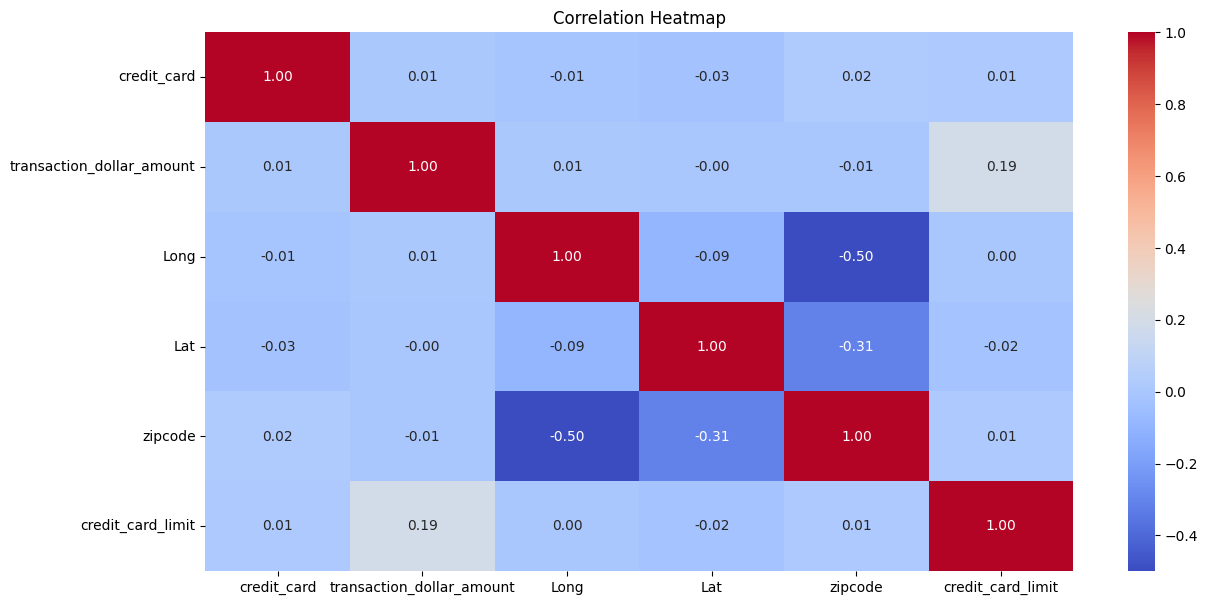

In [15]:
#Heatmap of correlation between numerical features
plt.figure(figsize=(14, 7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [16]:
class FraudDetectionModel:
    def __init__(self, df):
        self.df = df
        self.feature_columns = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit']
        self.model = None
        self.kmeans = None

    def data_preprocessing(self):
        scaler = StandardScaler()
        self.df[self.feature_columns] = scaler.fit_transform(self.df[self.feature_columns])

    def build_kmeans(self, n_clusters=2):
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def create_labels(self):
        if self.kmeans is None:
            raise ValueError("K-means model has not been built yet. Please call 'build_kmeans' first.")

        self.kmeans.fit(self.df[self.feature_columns])

        self.df['cluster_label'] = self.kmeans.predict(self.df[self.feature_columns])

        cluster_fraud_label = self.df.groupby('cluster_label')['transaction_dollar_amount'].mean().idxmax()
        self.df['is_fraudulent'] = self.df['cluster_label'].apply(lambda x: 1 if x == cluster_fraud_label else 0)


    def visualize_fraudulent_transactions(self):
        plt.figure(figsize=(15, 8))
        sns.scatterplot(data=df, x='credit_card_limit', y='transaction_dollar_amount', hue = 'is_fraudulent')
        plt.title('Credit Card Limit vs. Transaction Dollar Amount')
        plt.xlabel('Credit Card Limit')
        plt.ylabel('Transaction Dollar Amount')
        plt.show()

    def build_model(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(len(self.feature_columns),)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self, X_train, y_train, epochs=10, batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    def evaluate_model(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)

        y_pred = (self.model.predict(X_test) > 0.5).astype(int).flatten()
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


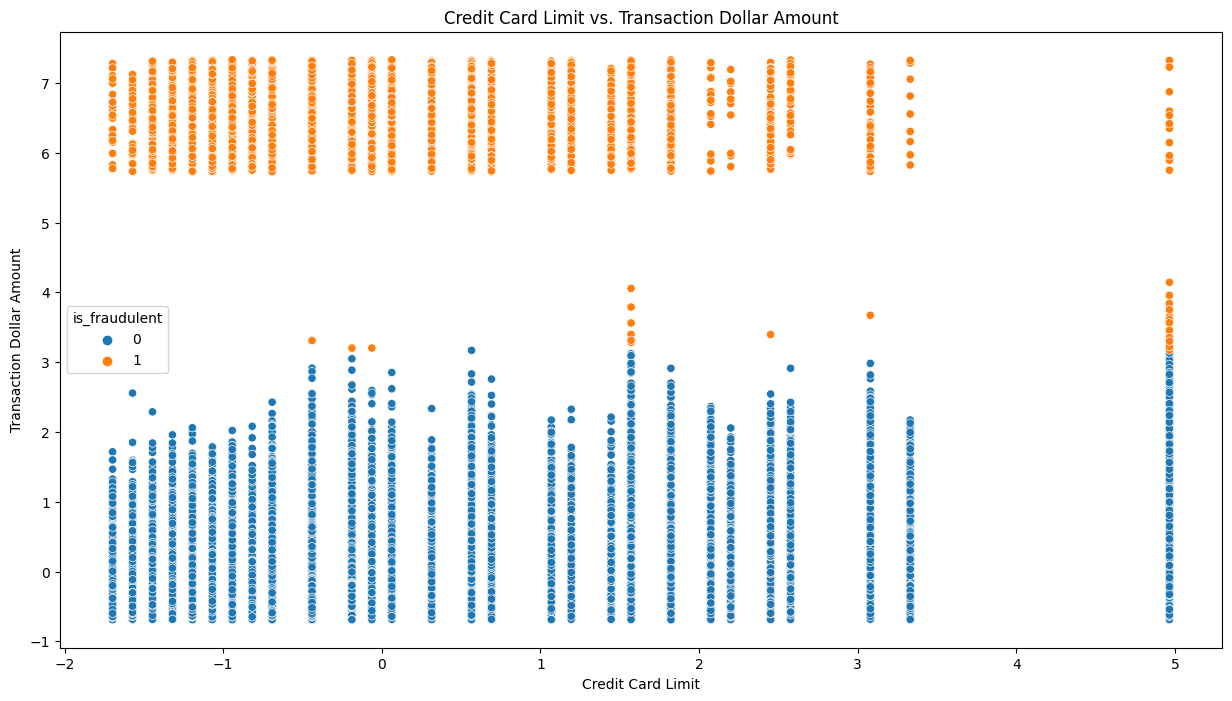

Model Training Complete.
1842/1842 [==============================] - 3s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57830
           1       1.00      1.00      1.00      1088

    accuracy                           1.00     58918
   macro avg       1.00      1.00      1.00     58918
weighted avg       1.00      1.00      1.00     58918

Confusion Matrix:
[[57830     0]
 [    0  1088]]


In [17]:
if __name__ == "__main__":

    model = FraudDetectionModel(df)
    model.data_preprocessing()
    model.build_kmeans()
    model.create_labels()

    model.visualize_fraudulent_transactions()

    X = model.df[model.feature_columns].values
    y = model.df['is_fraudulent'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.build_model()
    model.train_model(X_train, y_train, epochs=10, batch_size=32)

    print("Model Training Complete.")

    model.evaluate_model(X_test, y_test)

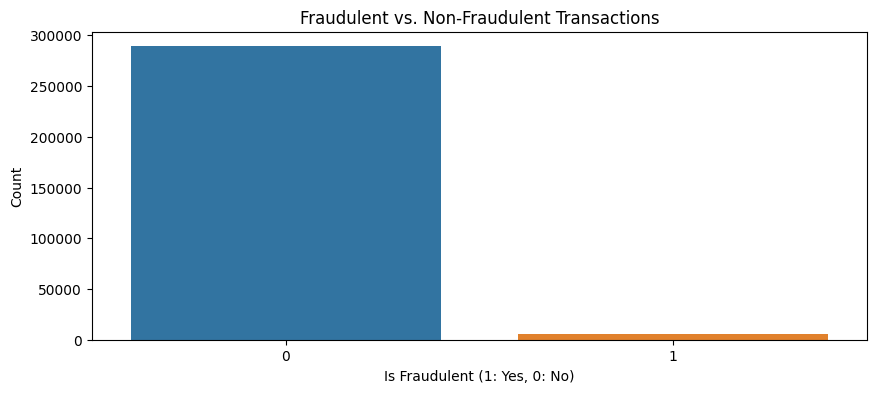

In [18]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='is_fraudulent')
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraudulent (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()

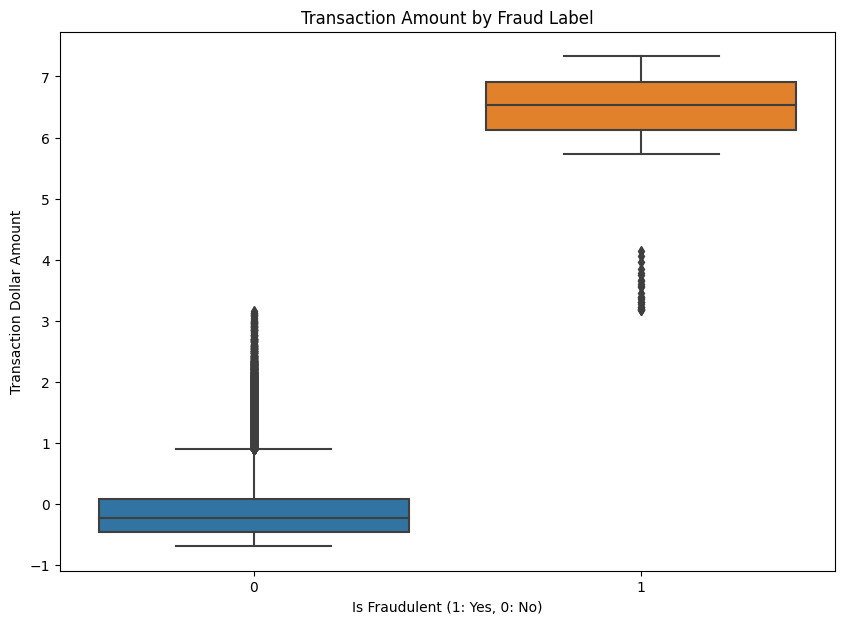

In [19]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='is_fraudulent', y='transaction_dollar_amount')
plt.title('Transaction Amount by Fraud Label')
plt.xlabel('Is Fraudulent (1: Yes, 0: No)')
plt.ylabel('Transaction Dollar Amount')
plt.show()

<ipython-input-20-92d836a39865>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


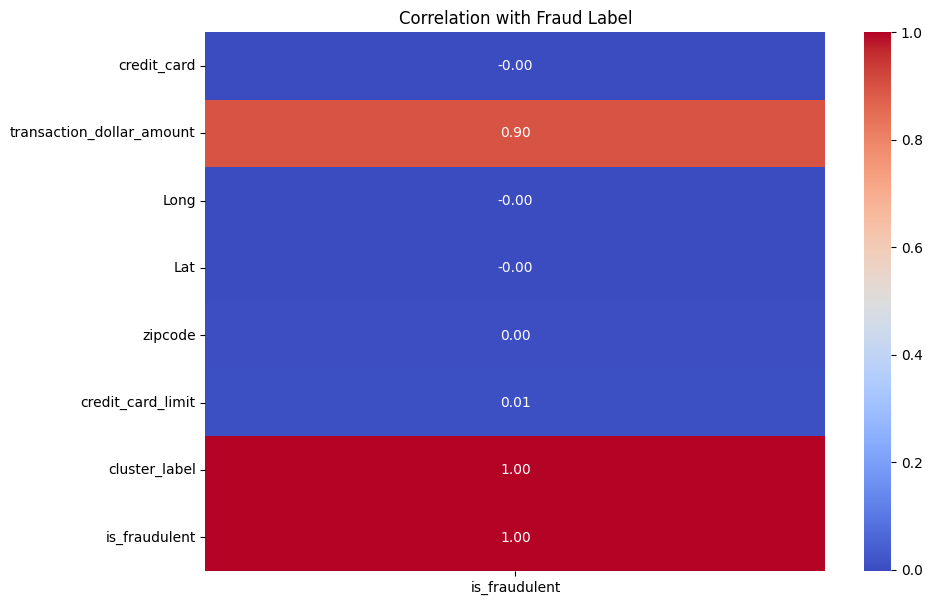

In [20]:
#correlation of fraud transaction with other features
plt.figure(figsize=(10, 7))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix[['is_fraudulent']], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with Fraud Label')
plt.show()

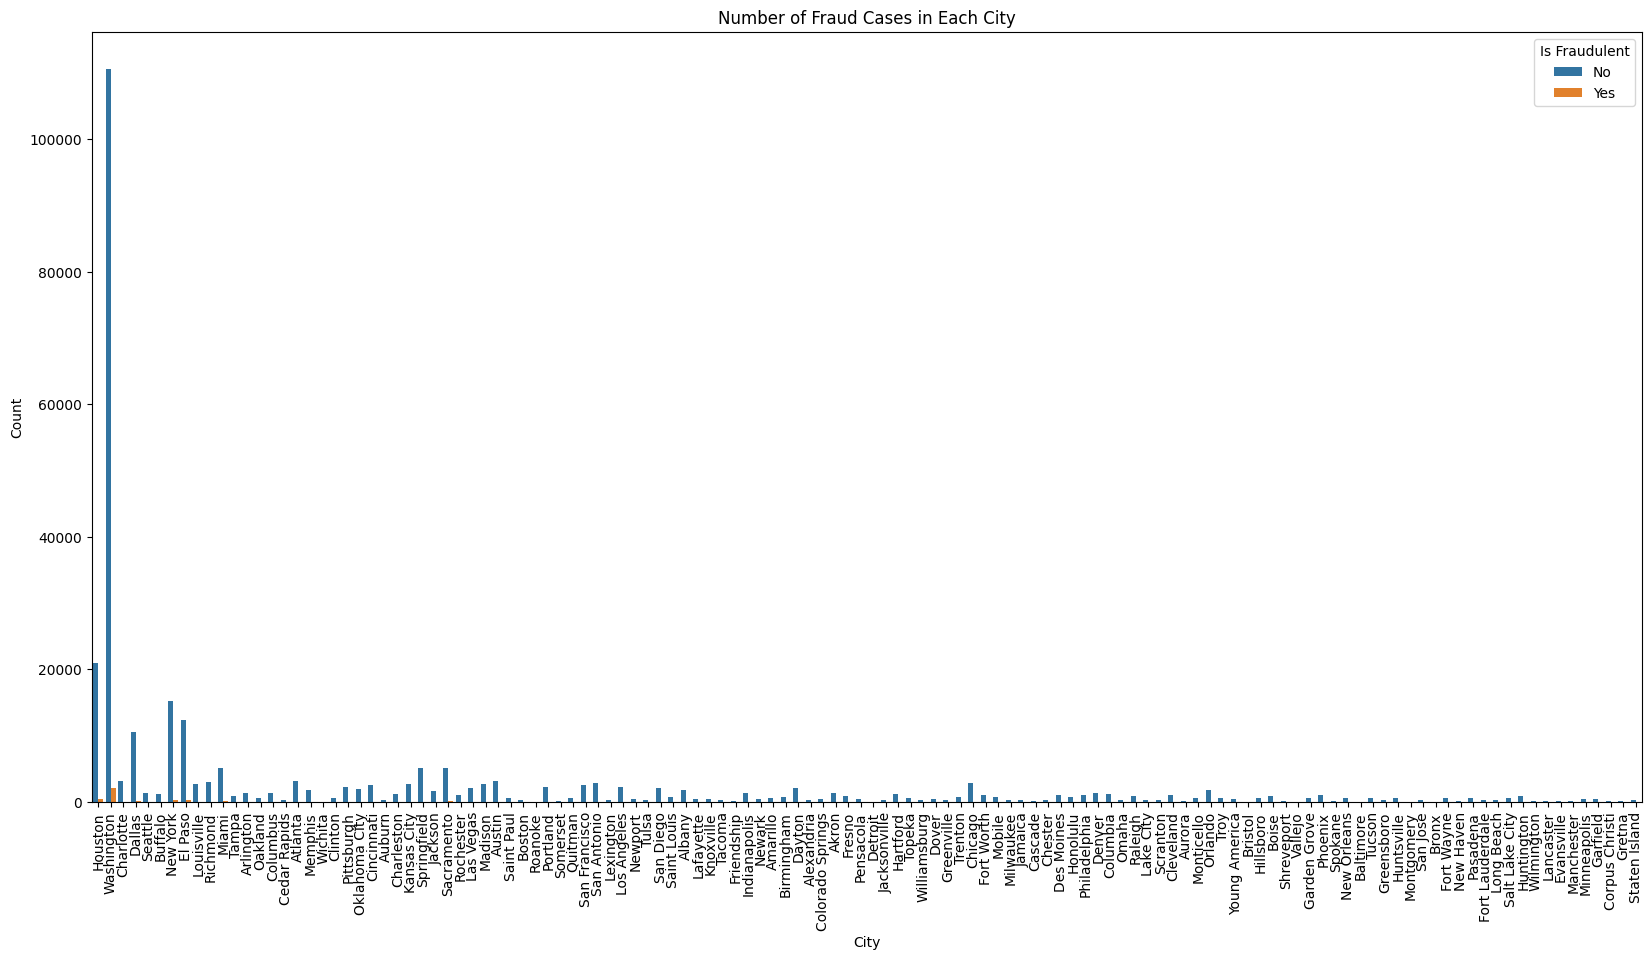

In [21]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='city', hue='is_fraudulent')
plt.title('Number of Fraud Cases in Each City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Is Fraudulent', labels=['No', 'Yes'])
plt.show()

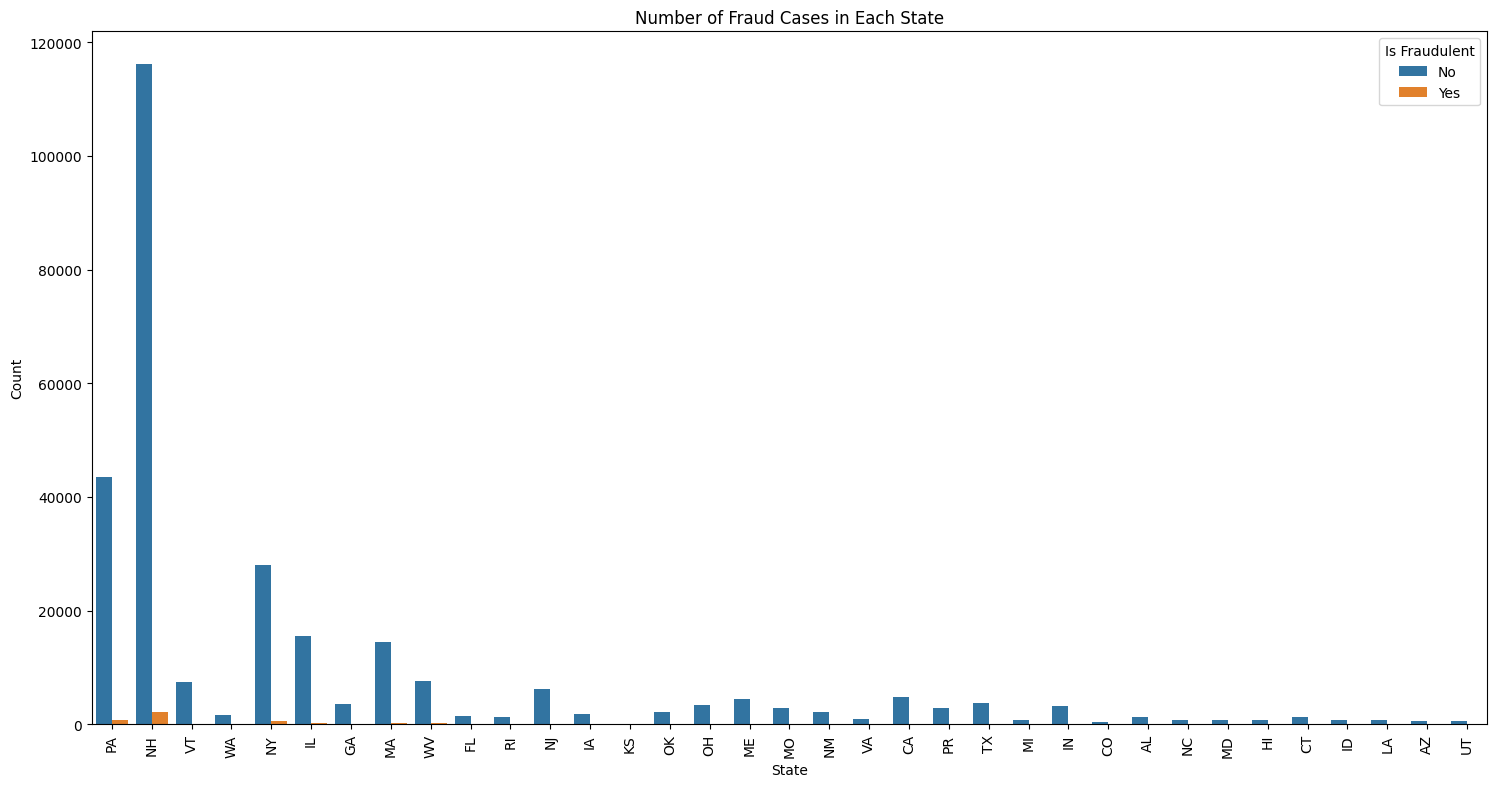

In [22]:
plt.figure(figsize=(18, 9))
sns.countplot(data=df, x='state', hue='is_fraudulent')
plt.title('Number of Fraud Cases in Each State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Is Fraudulent', labels=['No', 'Yes'])
plt.show()